In [1]:
# import modules, the function Read(), and the class CenterOfMass()
import numpy as np
import astropy.units as u
import astropy.constants as const 
import matplotlib.pyplot as plt

from astropy.constants import G 
from ReadFile import Read
from CenterOfMass import CenterOfMass

In [2]:
class MassProfile:
# Class to determine the mass distribution of a 
# of a given galaxy and simulation snapshot

    #part 1
    def __init__(self, galaxy, snap):
        ''' Class that calculates the mass profile of a given galaxy. 
            
        PARAMETERS
        ----------
        galaxy -- (string) the name of the galaxy we want to analyze
        snap -- (int) the simulation snapshop number

        '''

        #reconstructing the filename
        ilbl = '000' + str(snap) #add a string of the filenumber to the value '000' (snap number 0)
        ilbl = ilbl[-3:] #remove all but the last 3 digits
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'

        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)                                                                                             

        # storing mass and positions
        self.m = self.data['m']
        self.x = self.data['x']
        self.y = self.data['y']
        self.z = self.data['z']

        #storing the name of the galaxy 
        self.gname = galaxy 

    #part 2: Mass Enclosed
    def MassEnclosed(self, ptype, radius):
        ''' Method to compute the mass enclosed within a given radius of the COM for a specified
        galaxy and a specified snapnumber
        
        PARAMETERS
        ----------
        ptype -- (int -- 1,2,3) the particle type
        radius -- (array) an array of radii magnitudes 
        
        RETURNS
        -------
        mass_sum -- (array) an array made up of the mass enclosed within a given radius,
        with astropy units Msun
        '''
        #creating CenterOfMass object. use disk particles (type = 2) to determine COM. 
        COM = CenterOfMass(self.filename,2) 

        #create an array to store indexes of particles of desired Ptype                                
        index = np.where(self.data['type'] == ptype)

        #calling COM_P, which determines the center of mass of the given galaxy
        COM_p = COM.COM_P(0.1)
        #print(COM_p) #test

        #grabbing the particle masses from galaxy file
        pmass = self.m[index]
        
        #determining particle positions relative to the COM of the given galaxy
        px = self.x[index] - (COM_p[0]).value
        py = self.y[index] - (COM_p[1]).value
        pz = self.z[index] - (COM_p[2]).value

        #determining the radius (relative to the COM) of the particle
        pradius = np.sqrt(px**2 + py**2 + pz**2) 
        
        #create array that will store the sum of the masses within the enclosed radius. 
        #initialize with zeros.
        #zeros_like() makes it the same size as the radius arrray. 
        mass_sum = np.zeros_like(radius)

        #looping over the given radius array. i is the index and r is the actual value of the radius
        #array at index i 
        for i, r in enumerate(radius):
            r_enc = np.where(pradius < r) #finding all the particle radii inside of the specified radius
            mass_enc = pmass[r_enc] #grabbing the relevant masses from the particles inside the radius
            mass_sum[i] =  np.sum(mass_enc) #adding all masses enclosed together & adding the sum to the array. 
            
        #giving elements of mass array the proper units (Solar Mass)
        mass_sum = mass_sum*10**(10)*u.Msun

        return mass_sum

    #part 3: Total Mass Enclosed
    def MassEnclosedTotal(self, radius):
        ''' Method to compute the total mass (disk + bulge + halo) enclosed within a given radius by calling 
        MassEnclosed()
        
        PARAMETERS
        ----------
        radius -- (array) an array of radii magnitudes 
        
        RETURNS
        -------
        M_tot -- (array) an array of masses, with astropy units Msun
        '''
    #M33 has no bulge, so we only need the mass of the halo and disk. Use galaxy name to determine which galaxy 
    #is being read in.
        if self.gname == "M33":
            M_halo = self.MassEnclosed(1,radius)
            M_disk = self.MassEnclosed(2,radius)
            M_total = M_halo + M_disk
            return M_total #M_total is in Solar Masses 
        else:
            M_halo = self.MassEnclosed(1,radius)
            M_disk = self.MassEnclosed(2,radius)
            M_bulge = self.MassEnclosed(3,radius)
            M_total = M_halo + M_disk + M_bulge
            return M_total
            
        
    #part 4: Hernquist Mass
    def HernquistMass(self,r,h_a, m_halo):
        """ Function that defines the Hernquist 1990 mass profile 
        
        PARAMETERS
        ----------
        r -- (astropy quantity) Galactocentric distance in kpc 
        h_a -- (astropy quantity) scale radius of the Hernquist profile in kpc
        m_halo -- (float) total halo mass in Msun
        
        RETURNS
        -------
        M_hernquist -- (array) total mass within the input radius r in Msun
        """
        #M = m_halo*r**2/(a + r)**2
    
        a = m_halo #constant

        b = r**2/(h_a + r)**2
    
        M_hernquist = a * b # Hernquist Profile
    
        return M_hernquist*u.Msun

    #part 5: Circular Velocity
    def CircularVelocity(self, ptype, radius):
        ''' Method to compute the circular speed, using the mass enclosed at each radius.
        
        PARAMETERS
        ----------
        ptype -- (int -- 1,2,3) the particle type
        radius -- (array) an array of radii magnitudes 
        
        RETURNS
        -------
        circ_vel -- (array) an array of the circular speeds in km/s
        '''
        #v_c = sqrt(G*M_i/R) where i is (1,2,3) for each particle type
        
        #giving G the correct units 
        grav_const = ((const.G).to(u.kpc*u.km**2/u.s**2/u.Msun)).value
        
        #making empty array to hold circular velocity values
        circ_vel = np.zeros_like(radius)
        
        #calling MassEnclosed to get the mass enclosed in a certain r of a particular particle type 
        tot_mass = self.MassEnclosed(ptype,radius)
        
        for i,r in enumerate(radius):
            circ_vel[i] = np.sqrt(grav_const*(tot_mass[i]).value/r) 
        
        return circ_vel

        
    #part 6: Total Circular Velocity
    def CircularVelocityTotal(self, radius):
        ''' Method to compute the total circular speed, using the mass enclosed at each radius.
        
        PARAMETERS
        ----------
        radius -- (array) an array of radii magnitudes 
        
        RETURNS
        -------
        circ_vel_tot -- (array) an array of the circular speeds in km/s, representing the total 
        circular velocity created by all galaxy components at each r of the radius array input 
        '''
        #v_c = sqrt(G*M_tot/R)
        
        #giving G the correct units 
        grav_const = ((const.G).to(u.kpc*u.km**2/u.s**2/u.Msun)).value
        
        #making empty array to hold circular velocity values
        circ_vel_tot = np.zeros_like(radius)
        
        #calling TotalMassEnclosed
        tot_mass = self.MassEnclosedTotal(radius)
        
        for i,r in enumerate(radius):
            circ_vel_tot[i] = np.sqrt(grav_const*(tot_mass[i]).value/r) 
        
        return circ_vel_tot
        
    #part 7: Hernquist Circular Speed
    def HernquistVCirc(self, r,h_a, m_halo):
        """ Method to determine the circular velocity using the Hernquist mass profile 
        
        PARAMETERS
        ----------
        r -- (astropy quantity) Galactocentric distance in kpc
        h_a -- (astropy quantity) scale radius of the Hernquist profile in kpc
        m_halo -- (float) total halo mass in units of Msun 
        
        RETURNS
        -------
        hernquist_vcirc -- (array) an array of circular speeds in km/s
        """
        #v_c = sqrt(G*M_tot/R)
        
        #giving G the correct units 
        grav_const = ((const.G).to(u.kpc*u.km**2/u.s**2/u.Msun)).value
        
        #making empty array to hold circular velocity values
        hernquist_vcirc = np.zeros_like(radius)
        
        #calling TotalMassEnclosed
        mass = self.HernquistMass(r,h_a,m_halo)
        
        for i,r in enumerate(radius):
            hernquist_vcirc[i] = np.sqrt(grav_const*(mass[i]).value/r) 
            
        return hernquist_vcirc
        


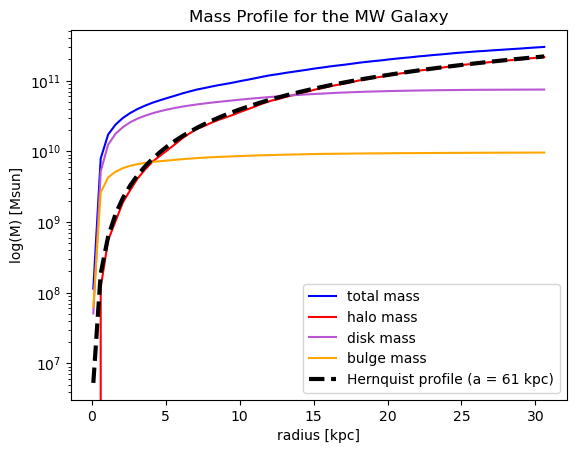

In [3]:
#part 8: mass profile plots

#MASS PROFILE OF THE MW

#make radius array from 0 to 30
radius = np.arange(0.1,31,.5)
#print(radius) #test

#creating MassProfile Object 
MW_profile = MassProfile("MW", 000)

#calling MassEnclosed to get the mass enclosed at each radius of each galaxy componeny for the galaxy 
MW_halo = MW_profile.MassEnclosed(1,radius)
MW_disk = MW_profile.MassEnclosed(2,radius)
MW_bulge = MW_profile.MassEnclosed(3,radius)

#calling MassEnclosedTotal to get the total mass profile
MW_mass = MW_profile.MassEnclosedTotal(radius)

#calling HernquistMass to get the Hernquist profile 
MW_hernquist = MW_profile.HernquistMass(radius,61,1.975*10**12)

#creating the plot 
fig,ax = plt.subplots()

#plotting y axis in log scale
ax.semilogy(radius, MW_mass, color = "blue", label = "total mass")
ax.semilogy(radius, MW_halo, color = "red", label = "halo mass" )
ax.semilogy(radius, MW_disk, color = "mediumorchid", label = "disk mass")
ax.semilogy(radius, MW_bulge, color = "orange", label = "bulge mass")
ax.semilogy(radius, MW_hernquist, color = "black", label = "Hernquist profile (a = 61 kpc)", linewidth = "3", linestyle = "--")

#making axes labels and setting the legend to show
ax.set_title ("Mass Profile for the MW Galaxy")
ax.set_ylabel("log(M) [Msun]")
ax.set_xlabel("radius [kpc]")
ax.legend()

# save the file 
fig.savefig("MWMassProfile.png")